# Character Recommender

In [147]:
import pandas as pd
import pickle

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

In [148]:
df = pd.read_csv('../data/clean_scripts.csv', index_col=0)
df.dropna(inplace=True)

In [149]:
df.head()

,Character,Dialogue,EpisodeNo,SEID,Season,clean_dialogue
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0,Do you know what this is all about? Do you kno...
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0,"See, to me, that button is in the worst possi..."
2,GEORGE,Are you through?,1.0,S01E01,1.0,Are you through?
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0,"You do of course try on, when you buy?"
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0,"Yes, it was purple, I liked it, I dont actuall..."


In [150]:
# Data only with main character lines
df = df[(df['Character'] == 'JERRY') |
        (df['Character'] == 'GEORGE') |
        (df['Character'] == 'KRAMER') |
        (df['Character'] == 'ELAINE')]

In [151]:
# Checking the proportions
df['Character'].value_counts(normalize=True)

JERRY     0.378687
GEORGE    0.247734
ELAINE    0.203733
KRAMER    0.169846
Name: Character, dtype: float64

In [152]:
# Switching to Numeric
df['character_numeric'] = df['Character'].replace({
    'JERRY': 0,
    'GEORGE': 1,
    'KRAMER': 2,
    'ELAINE': 3
})

In [153]:
# Lemmetization function
def lem_preprocess(text):
    lemmatizer = WordNetLemmatizer()
    t = word_tokenize(text.lower())
    l = [lemmatizer.lemmatize(word) for word in t]
    return ' '.join(l)

In [154]:
# Lemmetizing dialogue
df['lem_dialogue'] = df['Dialogue'].apply(lem_preprocess)

In [155]:
df.head()

,Character,Dialogue,EpisodeNo,SEID,Season,clean_dialogue,character_numeric,lem_dialogue
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0,Do you know what this is all about? Do you kno...,0,do you know what this is all about ? do you kn...
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0,"See, to me, that button is in the worst possi...",0,"( pointing at george shirt ) see , to me , tha..."
2,GEORGE,Are you through?,1.0,S01E01,1.0,Are you through?,1,are you through ?
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0,"You do of course try on, when you buy?",0,"you do of course try on , when you buy ?"
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0,"Yes, it was purple, I liked it, I dont actuall...",1,"yes , it wa purple , i liked it , i dont actua..."


In [189]:
# Setting X and y
X = df['lem_dialogue']
y = df['character_numeric']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

**Logistic Regression**

In [202]:
# Pipeline with CountVectorizer and LogisticRegression
pipe = make_pipeline(CountVectorizer(stop_words='english', preprocessor=lem_preprocess), LogisticRegression(max_iter=10000))

# Fitting
pipe.fit(X_train, y_train)

# Scoring
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.6251454781953858
0.42951021665468736


In [198]:
# # Save SVC
# # Best Train Score: .6251, Test Score: .4296

# with open('../data/logisticregression_model.pkl', 'wb') as f:
#     pickle.dump(pipe, f)

**Support Vector Classifier**

In [134]:
# Pipeline with TfidfVectorizer and SVC
svc_pipe = make_pipeline(TfidfVectorizer(stop_words='english'), SVC())

# Fitting
svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('svc', SVC())])

In [137]:
# Scoring
print(svc_pipe.score(X_train, y_train))
print(svc_pipe.score(X_test, y_test))

0.7263640720202642
0.42417085943115307


In [139]:
# Checking predictions
preds = svc_pipe.predict(X)

# Checking proportions
pd.DataFrame(preds).value_counts(normalize=True)

0    0.630401
1    0.164172
2    0.103766
3    0.101661
dtype: float64

**Boosting Classifiers**

In [358]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [359]:
# Creating pipeline
boost_pipe = make_pipeline(TfidfVectorizer(stop_words='english'), GradientBoostingClassifier(n_estimators=200))

# Fitting
boost_pipe.fit(X_train, y_train)

# Scoring
print(boost_pipe.score(X_train, y_train))
print(boost_pipe.score(X_test, y_test))

0.4708567535343212
0.42213366033108524


**Sentiment Analysis**

In this section I tried to see if sentiment would be a good predicter of character. It wasn't

In [169]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [170]:
scores = ['neg', 'neu', 'pos', 'compound']
analyzer = SentimentIntensityAnalyzer()

for score in scores:
    df[score] = df['Dialogue'].apply(lambda x: analyzer.polarity_scores(x).get(score))

Kramer is the most positive character in Seinfeld. Jerry is the most negative

In [173]:
df.groupby('Character').mean()

,EpisodeNo,Season,character_numeric,neg,neu,pos,compound
Character,,,,,,,
ELAINE,11.526619,5.701992,4,0.051904,0.813407,0.134688,0.092363
GEORGE,11.054182,5.461372,1,0.054402,0.814977,0.130621,0.094971
JERRY,10.899635,5.438185,0,0.052848,0.820637,0.126514,0.073984
KRAMER,11.456032,5.981092,2,0.043838,0.812066,0.144098,0.120608


In [177]:
# Setting new X
X = df[['neg', 'neu', 'pos']]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Instantiating LogisticRegression
logreg = LogisticRegression()

# Fitting
logreg.fit(X_train, y_train)

# Scoreing
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

## Scoring on Iconic Quotes

In [203]:
def predict_character(text, model):
    prediction = model.predict([text])
    if prediction == 0:
        return 'Jerry'
    elif prediction == 1:
        return 'George'
    elif prediction == 2:
        return 'Kramer'
    elif prediction == 3:
        return 'Elaine'

In [204]:
jerry_quote = 'What is the deal with peanuts? Are they peas or are they nuts? Make up your mind!'
kramer_quote = 'I\'m out there, Jerry, and I\'m loving every minute of it!'
george_quote = 'I’m Disturbed, I’m Depressed, I’m Inadequate – I’ve Got It All!'
elaine_quote = "Maybe the dingo ate your baby!"
quotes = {'Jerry': jerry_quote, 
          'Kramer': kramer_quote, 
          'George': george_quote, 
          'Elaine': elaine_quote}

In [205]:
for character, quote in quotes.items():
    print(f'The model classifies the {character} quote as {predict_character(quote, pipe)}.')

The model classifies the Jerry quote as Jerry.
The model classifies the Kramer quote as Kramer.
The model classifies the George quote as George.
The model classifies the Elaine quote as Elaine.


**Iconic Quotes Classification**

In [208]:
# Dataframe of Iconic Quotes

quotes = pd.DataFrame({'Dialogue': ['Sex, that’s meaningless, I can understand that, but dinner; that’s heavy. That’s like an hour.', 
                                    'She said I wasn’t sponge-worthy. Wouldn’t waste a sponge on me.',
                                    'Oh I gotta get on that internet, I’m late on everything!',
                                    'Boutros Boutros-Ghali.',
                                    'You know, the very fact that you oppose this makes me think I’m on to something.',
                                    'You’re a nice guy, but I actually only have three friends. I can’t really handle any more.',
                                    'If every instinct you have is wrong, then the opposite would have to be right.',
                                    'My dream is to become hopeless.',
                                    'Food and sex. Those are my two passions.',
                                    'The sea was angry that day my friends.',
                                    'Jerry, just remember, it’s not a lie if you believe it.',
                                    'I lie every second of the day. My whole life is a sham.',
                                    'I’m disturbed, I’m depressed, I’m inadequate. I’ve got it all!',
                                    'I feel like my old self again. Totally inadequate, completely insecure, paranoid, neurotic. It’s a pleasure.',
                                    'I can’t do this anymore, it’s too long! Just tell your stupid story about the stupid desert and just die already! Die!',
                                    'I’m Queen of the castle.',
                                    'I don’t think George has ever thought he’s better than anybody.',
                                    'It’s not fair people are seated first come, first served. It should be based on who’s hungriest.',
                                    'Maybe the dingo ate your baby!',
                                    'I just couldn’t decide if he was really sponge-worthy.',
                                    'We don’t know how long this will last. They are a very festive people.',
                                    'I’m out there Jerry and I’m lovin’ every minute of it.',
                                    'What have you done to my little cable boy?',
                                    'Giddy-up',
                                    'Boy, these pretzels are making me thirsty.',
                                    'Yama hama, it’s fright night!',
                                    'Do you have any idea how much time I waste in this apartment?',
                                    'Those are my everyday balloons.'],
                      'Character': ['Jerry'] * 7 + ['George'] * 7 + ['Elaine'] * 7 + ["Kramer"] * 7})
                      








In [209]:

quotes['character_numeric'] = quotes['Character'].replace({'Jerry': 0,
                                                           'George': 1,
                                                           'Kramer': 2,
                                                           'Elaine': 3})

In [210]:
quotes['lem'] = quotes['Dialogue'].apply(lem_preprocess)

In [218]:
X_quotes = quotes['Dialogue']
y_quotes = quotes['character_numeric']
pipe.score(X_quotes, y_quotes)

0.5714285714285714

Text(0.5, 1.0, 'Seinfeld Character Quotes')

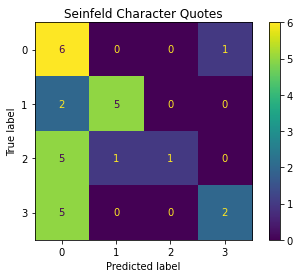

In [219]:
plot_confusion_matrix(model, X_quotes, y_quotes)
plt.title("Seinfeld Character Quotes")
#plt.savefig('confusion_matrix.png');

## Saving Quality Models

In [138]:
# # Save SVC

# with open('../data/svc_classification_model.pkl', 'wb') as f:
#     pickle.dump(svc_pipe, f)